# US Adult Income

## Purpose of the project

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
...
</div>

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam

from fairlearn.metrics import demographic_parity_difference, MetricFrame, mean_prediction, equal_opportunity_difference

import aif360
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.preprocessing.reweighing import Reweighing
from fairxplainer.fair_explainer import FairXplainer
from fairxplainer.fair_explainer import plot as fif_plot
from fairxplainer import utils

import multiprocessing

c:\Users\ol200\AppData\Local\Programs\Python\Python311\Lib\site-packages\inFairness\utils\ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
c:\Users\ol200\AppData\Local\Programs\Python\Python311\Lib\site-packages\inFairness\utils\ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrat

## Table of Contents

- [1. Dataset](#dataset) 
    - [a. Description](#description) 
    - [b. Data cleaning](#data-cleaning)
- [2. Bias](#bias)
    - [a. Sensitive features](#sensitive-features) 
    - [b. Detailed sensitive groups](#detailed-sensitive-groups)
    - [c. Preprocess](#preprocess) 
    - [d. Define MLP](#define-mlp) 
    - [e. Preparing sets](#preparing-sets) 
    - [f. Training](#training)
    - [g. Classification performance](#classification-performance)
    - [e. Fairness quantification with fairlearn](#fairness-quantification-with-fairlearn)


## Dataset

### Description

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

The US Adult Income dataset, sourced from [Kaggle](https://www.kaggle.com/datasets/johnolafenwa/us-census-data), was originally extracted by Barry Becker from the 1994 US Census Database. It contains anonymous data about various social and economic factors, including occupation, age, native country, race, capital gain, capital loss, education, work class, and more.

Each entry in the dataset is labeled based on income, categorizing individuals as earning either ">50K" or "<=50K" annually. This classification allows for the analysis of how different social factors correlate with income levels.

The dataset is divided into two CSV files:
* `adult-training.txt`: Contains data used for training models.
* `adult-test.txt`: Contains data used for testing models.

This dataset is commonly utilized for machine learning tasks focused on income prediction and social factor analysis.
</div>

### Data cleaning

##### Read data

In [2]:
# Define path to data files
train_file = "data/adult-training.csv"
test_file = "data/adult-test.csv"

In [3]:
# Define columns
COLUMNS = ["age", "workclass", "fnlwgt", "education","education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country", "income_bracket"]

In [4]:
# Read data into df
df_train = pd.read_csv(train_file, names = COLUMNS, skipinitialspace = True, engine= "python")
df_test = pd.read_csv(test_file, names = COLUMNS, skipinitialspace = True, skiprows=1, engine = "python")

##### Investigate the data

In [5]:
# Set size
print("Train set :", df_train.shape)
print("Test set :", df_test.shape)

Train set : (32561, 15)
Test set : (16281, 15)


In [6]:
# Check if there are any missing (NaN) values in the DataFrame
print("Any missing (NaN) values in the train set ? :", df_train.isnull().values.any())
print("Any missing (NaN) values in the test set ? :", df_test.isnull().values.any())

Any missing (NaN) values in the train set ? : False
Any missing (NaN) values in the test set ? : False


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
&rarr; We don't need to remove NaN values
</div>

In [7]:
# Display the first few rows of the training data to verify
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Distribution of income values :
</div>

In [8]:
#  in train set
df_train.income_bracket.value_counts(normalize=True)

income_bracket
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64

In [9]:
# Distribution of income values in test set
df_test.income_bracket.value_counts(normalize=True)

income_bracket
<=50K.    0.763774
>50K.     0.236226
Name: proportion, dtype: float64

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Statistics on train set :
</div>

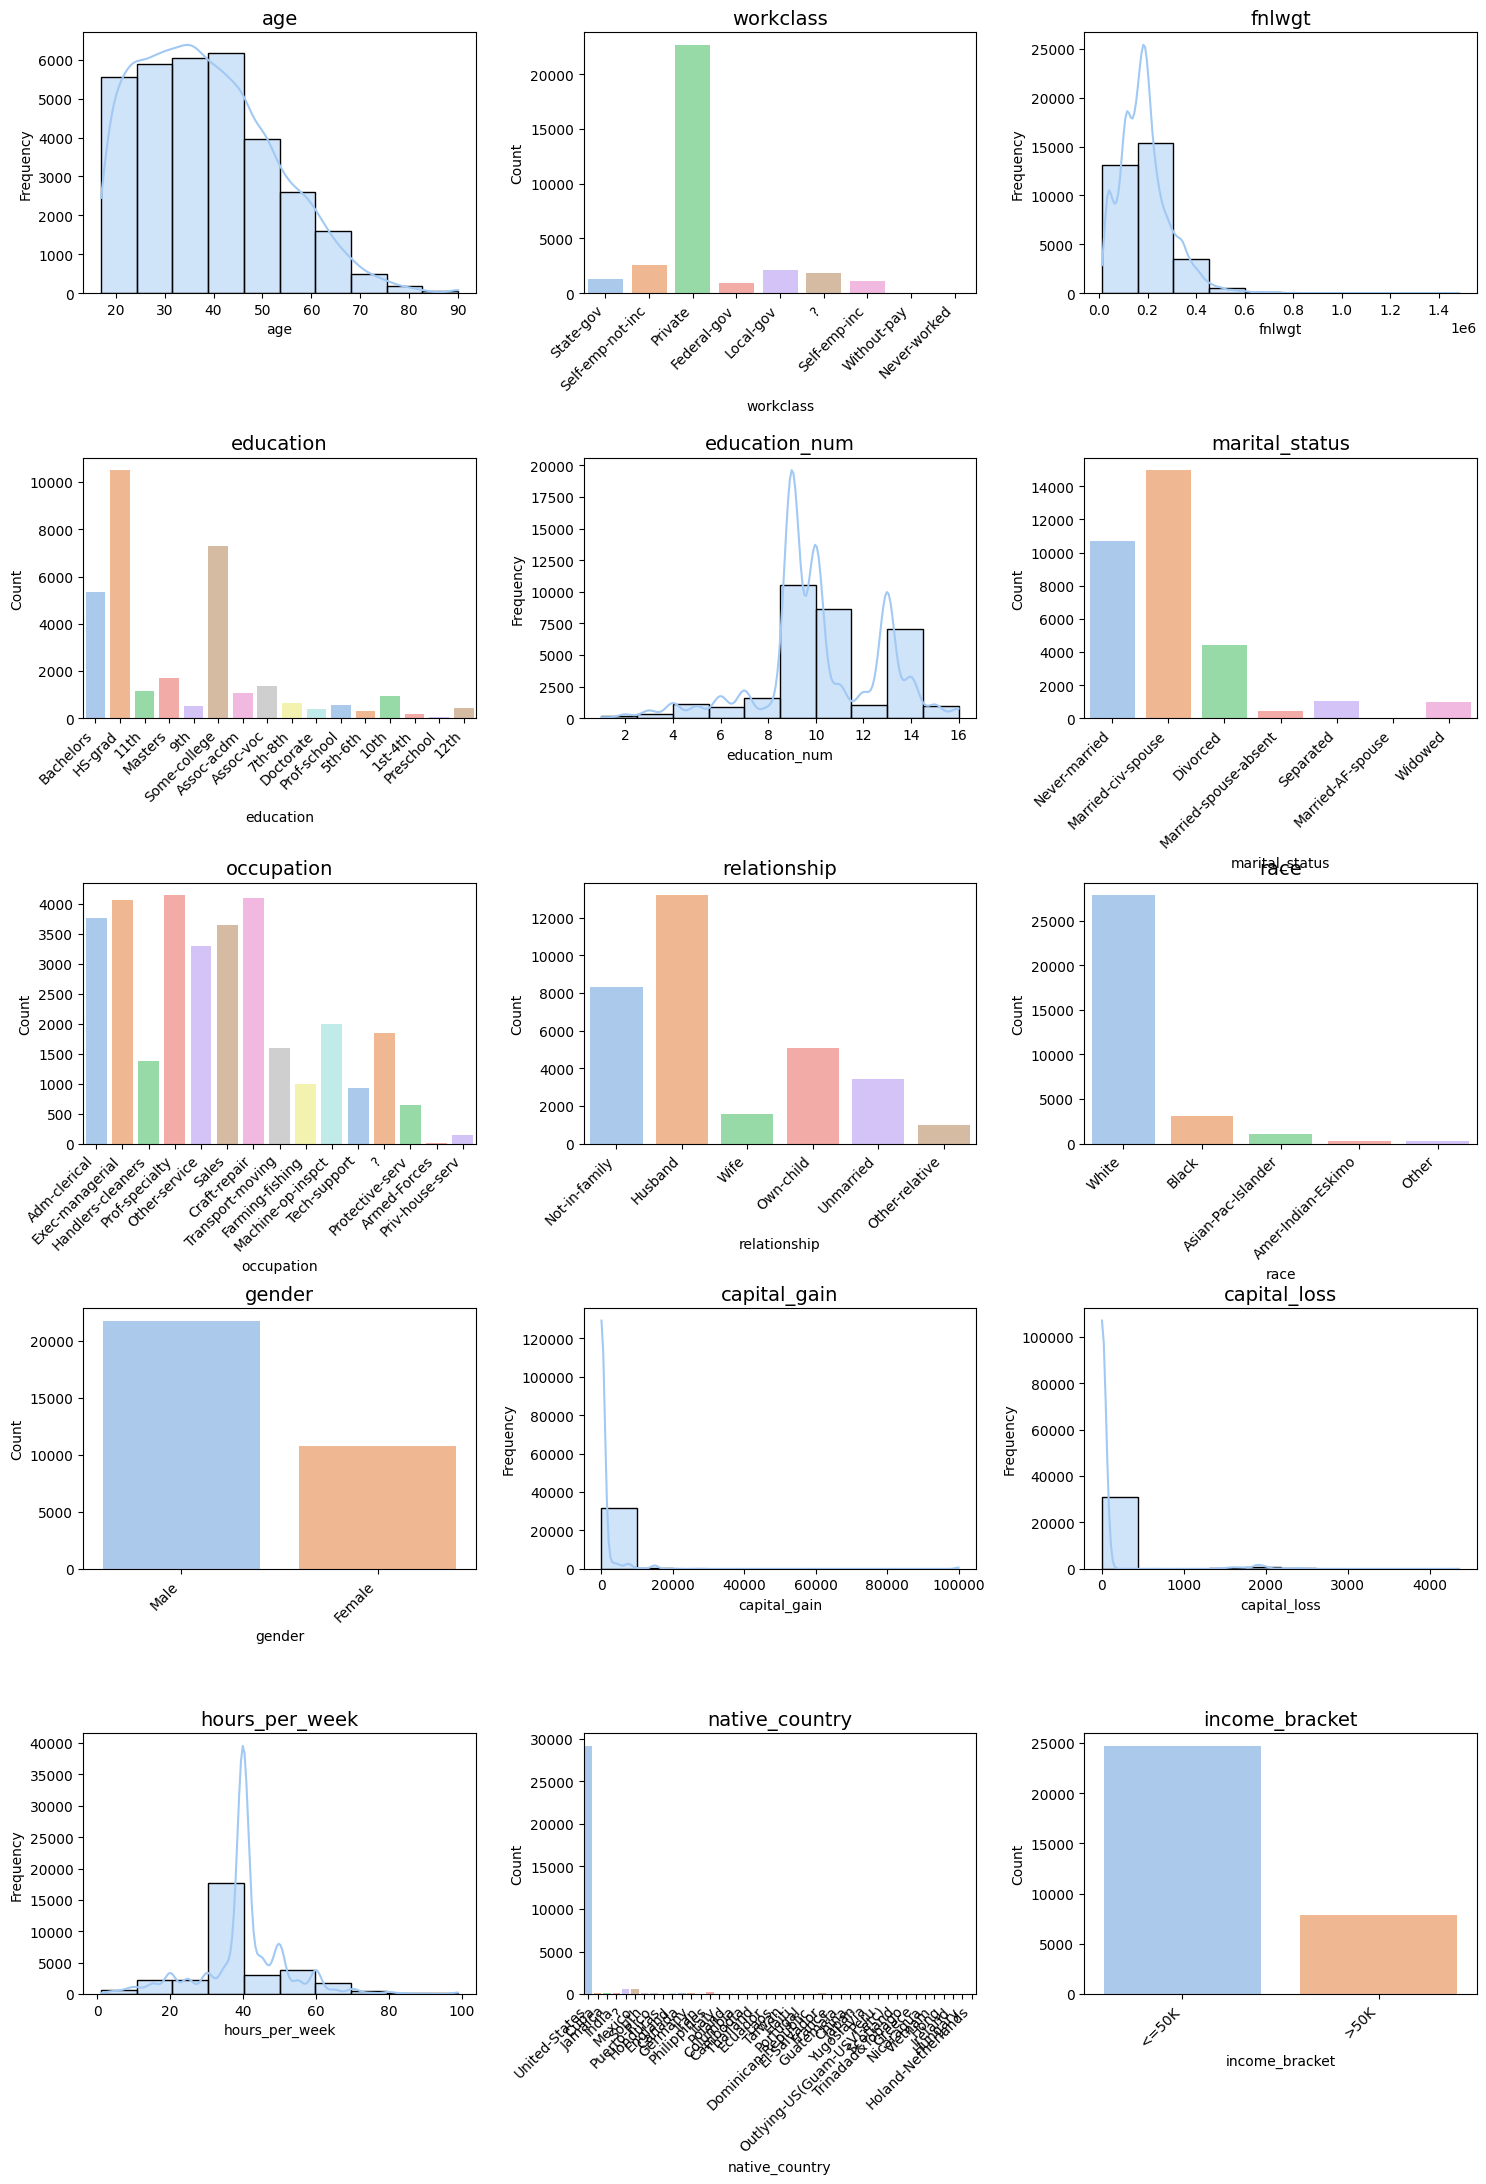

In [10]:
num_cols = 3
num_plots = len(df_train.columns)
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(df_train.columns):
    ax = axes[i]
    
    # Vérification du type de données
    if isinstance(df_train[column].dtype, pd.CategoricalDtype) or df_train[column].dtype == object:
        sns.countplot(x=column, hue=column, data=df_train, ax=ax, palette="pastel", legend=False)
        ax.set_ylabel("Count")
    
        ax.set_xticks(range(len(df_train[column].unique())))
        ax.set_xticklabels(df_train[column].unique(), rotation=45, ha='right')

    else:
        # Palette dynamique selon le nombre d'éléments uniques
        unique_vals = df_train[column].nunique()
        color = sns.color_palette("pastel", n_colors=unique_vals)
        
        sns.histplot(df_train[column], kde=True, bins=10, ax=ax, color=color[0])
        ax.set_ylabel("Frequency")
    
    ax.set_title(f"{column}", fontsize=14)

# Supprimer les sous-graphiques inutilisés
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()


##### Clean data

In [11]:
# Set label column
df_train['income_bracket'] = (df_train["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)
df_test['income_bracket'] = (df_test["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)

In [12]:
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


# Bias

### Sensitive features

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

We consider the following sensitive features:

* `race`- Risk of racial discrimination in economic decisions.
* `gender` - Pay differentials and gender stereotypes can introduce bias.
* `native_country` - Can be a proxy for socio-economic disparities based on origin.
* `age` - Can lead to discrimination linked to professional seniority or access to economic opportunities.
* `marital_status` - May be correlated with income inequalities based on societal norms.

Among them, gender is binary, age is continuous (requires binning) and the others are categorical


</div>

### Detailed sensitive groups

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**Gender**
* Male
* Female

**Age**
* Less than 30 years
* Between 30 and 40
* Between 40 and 50
* Greater than 50

**Race**
* White
* Black
* Asian-Pac-Islander
* Amer-Indian-Eskimo
* Other

**Marital Statut**
* Married
* Widowed
* Divorced
* Separated
* Never married
* Married-civ-spouse
* Married-AF-spouse

</div>

In [13]:
# List of original sensitive features before one-hot-encoding
original_sensitive_features = ['gender', 'race', 'marital_status']

### Preprocess

In [14]:
def preprocess(df):

    # Split the DataFrame into features (x) and target variable (y)
    x = df.copy()
    x.drop('income_bracket', axis=1, inplace=True)
    y = df['income_bracket']

    # Binning the age feature into groups
    x['age_less_than_30'] = x['age'] < 30
    x['age_between_30_and_40'] = (x['age'] >= 30) & (x['age'] < 40)
    x['age_between_40_and_50'] = (x['age'] >= 40) & (x['age'] < 50)
    x['age_greater_than_50'] = x['age'] >= 50
    # Dropping the original 'age' column after binning
    x.drop('age', axis=1, inplace=True)

    return x, y

### Preparing sets

##### Preparing the train set

In [15]:
x_train, y_train = preprocess(df_train)
x_train.head()

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50
0,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False,True,False,False
1,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False,False,False,True
2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False,True,False,False
3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False,False,False,True
4,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,True,False,False,False


In [16]:
# Convert categorical variables into dummy/indicator variables using one-hot encoding.
x_train_encoded = pd.get_dummies(x_train)
x_train_encoded.head()

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50,workclass_?,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,77516,13,2174,0,40,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,83311,13,0,0,13,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
2,215646,9,0,0,40,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,234721,7,0,0,40,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
4,338409,13,0,0,40,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
# Check if no columns are missing.
print([c for c in x_train_encoded.columns if c not in pd.get_dummies(df_train).columns])
print([c for c in pd.get_dummies(df_train).columns if c not in x_train_encoded.columns])

['age_less_than_30', 'age_between_30_and_40', 'age_between_40_and_50', 'age_greater_than_50']
['age', 'income_bracket']


In [18]:
# Scaling dataset
scaler = MinMaxScaler()
x_train_scaled = x_train_encoded.copy()
x_train_scaled[x_train_scaled.columns] = scaler.fit_transform(x_train_scaled[x_train_scaled.columns])
x_train_scaled.head()

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50,workclass_?,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,0.044302,0.800000,0.02174,0.0,0.397959,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.048238,0.800000,0.00000,0.0,0.122449,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.138113,0.533333,0.00000,0.0,0.397959,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.151068,0.400000,0.00000,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.221488,0.800000,0.00000,0.0,0.397959,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Under sampling, to train the model on a balanced train set
sampler = RandomUnderSampler(random_state=5)
subxtrain, subytrain = sampler.fit_resample(x_train_scaled, y_train)
subytrain.value_counts()

income_bracket
0    7841
1    7841
Name: count, dtype: int64

##### Preparing the test set

In [20]:
x_test, y_test = preprocess(df_test)
x_test.head()

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50
0,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,True,False,False,False
1,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,False,True,False,False
2,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,True,False,False,False
3,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,False,False,True,False
4,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,True,False,False,False


In [21]:
# Convert categorical variables into dummy/indicator variables using one-hot encoding.
x_test_encoded = pd.get_dummies(x_test)

# Ensure test set has the same columns as the train set
x_test_encoded = x_test_encoded.reindex(columns=x_train_encoded.columns, fill_value=0)

In [22]:
x_test_encoded.head()

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50,workclass_?,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,226802,7,0,0,40,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,89814,9,0,0,50,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,336951,12,0,0,40,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,160323,10,7688,0,40,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,103497,10,0,0,30,True,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False


In [23]:
# Scaling dataset
scaler = MinMaxScaler()
x_test_scaled = x_test_encoded.copy()
x_test_scaled[x_test_scaled.columns] = scaler.fit_transform(x_test_scaled[x_test_scaled.columns])
x_test_scaled.head()

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50,workclass_?,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,0.144430,0.400000,0.000000,0.0,0.397959,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.051677,0.533333,0.000000,0.0,0.500000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.219011,0.733333,0.000000,0.0,0.397959,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.099418,0.600000,0.076881,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.060942,0.600000,0.000000,0.0,0.295918,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [24]:
# Under sampling
sampler = RandomUnderSampler(random_state=5)
subxtest, subytest = sampler.fit_resample(x_test_scaled, y_test)
subytest.value_counts()

income_bracket
0    3846
1    3846
Name: count, dtype: int64

In [25]:

sampler = RandomUnderSampler(random_state=5)
subxtest_bis, subytest_bis = sampler.fit_resample(x_test, y_test)
subytest.value_counts()

income_bracket
0    3846
1    3846
Name: count, dtype: int64

In [26]:
subxtest_bis.head()

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50
15389,Private,305129,11th,7,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States,True,False,False,False
13987,?,358355,12th,8,Never-married,?,Unmarried,White,Female,0,0,35,United-States,True,False,False,False
3277,Private,275446,Some-college,10,Separated,Machine-op-inspct,Not-in-family,Black,Male,0,0,40,United-States,False,False,True,False
3184,Private,77521,11th,7,Never-married,Priv-house-serv,Unmarried,White,Female,0,0,40,United-States,False,False,False,True
2244,Private,297767,Masters,14,Married-civ-spouse,Prof-specialty,Husband,Black,Male,0,0,40,United-States,False,True,False,False


In [27]:
subxtest.head()

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,age_less_than_30,age_between_30_and_40,age_between_40_and_50,age_greater_than_50,workclass_?,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
15389,0.197465,0.400000,0.0,0.0,0.448980,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13987,0.233503,0.466667,0.0,0.0,0.346939,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3277,0.177366,0.600000,0.0,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3184,0.043353,0.400000,0.0,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2244,0.192480,0.866667,0.0,0.0,0.397959,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Define MLP

In [28]:
# Define the MLP model
mlp = Sequential([
        Input(shape=(subxtrain.shape[1],)),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

### Training

In [29]:
# Compilation and training
mlp.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
mlp.fit(subxtrain, subytrain, epochs=100, batch_size=32, verbose=0)

In [30]:
# Evaluate the model
yhat_train = (mlp.predict(subxtrain) >= 0.5).astype(int).ravel()
print("MLP Training Accuracy on train set :", accuracy_score(subytrain, yhat_train))

491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
MLP Training Accuracy on train set : 0.8865578370105854


### Classification Performance

In [31]:
yhat = (mlp.predict(subxtest) >= 0.5).astype(int).ravel()
print(classification_report(np.array(subytest), yhat, target_names=['<=50K', '>50K']))

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
              precision    recall  f1-score   support

       <=50K       0.84      0.79      0.81      3846
        >50K       0.80      0.85      0.82      3846

    accuracy                           0.82      7692
   macro avg       0.82      0.82      0.82      7692
weighted avg       0.82      0.82      0.82      7692



### Fairness quantification with Fairlearn

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

Fairness metrics help evaluate whether machine learning models treat different demographic groups equitably. 

- **Statistical Parity / Demographic Parity** ensures that the selection rate is the same across different demographic groups, regardless of their actual qualifications. It is useful when aiming for equal access to opportunities.  
- **Equality of Opportunity** ensures that individuals who truly qualify for a positive outcome (e.g., deserving a loan) have the same chance of being correctly classified, regardless of their demographic group. It focuses on fairness for those who deserve the opportunity.  
- **Predictive Value Parity (PVP)** ensures that when a model predicts a positive outcome, the likelihood of that prediction being correct is the same across groups. It is crucial in high-stakes decisions like medical diagnoses or criminal justice to maintain trust in predictions. * 

We consider 4 scenarios with different choices of sensitive features :
* Gender 
* Gender and marital status
* Race
* Race and gender

Statistical Parity can be particularly useful in ensuring that different groups, such as those defined by gender or race, have equal access to the opportunities predicted by the model, regardless of other personal characteristics.
</div>

##### Gender

In [72]:
# We compute P(Ŷ = 1 | Sex) using MetricFrame
gender_cond = MetricFrame(
    metrics=mean_prediction,
    y_true=subytest_bis,
    y_pred=yhat,
    sensitive_features=subxtest_bis['gender']
)

In [73]:
# We extract probabilities per group
probas = gender_cond.by_group.to_dict()

groups = list(probas.keys())
values = list(probas.values())

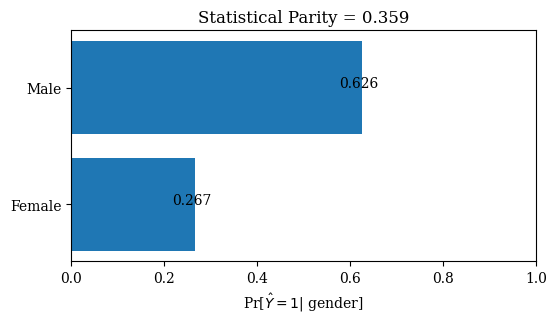

In [74]:
# Plot bar chart
fig, ax = plt.subplots(figsize=(6, 3))
ax.barh(groups, values)

# Add value labels on bars
for i, v in enumerate(values):
    ax.text(v - 0.05, i, f"{v:.3f}")

stat_parity = demographic_parity_difference(y_true=subytest_bis, y_pred=yhat, sensitive_features=subxtest_bis['gender'])
ax.set_xlabel(r"Pr[$\hat{Y} = 1 |$ gender]")
ax.set_title(f"Statistical Parity = {stat_parity:.3f}")
ax.set_xlim(0, 1)  # Adjust the x-axis range

plt.show()

In [75]:
eopp = equal_opportunity_difference(y_true=subytest_bis, 
                                    y_pred=yhat, 
                                    sensitive_features=subxtest_bis['gender'])
print(f"Equality of Opportunity Difference: {eopp:.3f}")

Equality of Opportunity Difference: 0.132


##### Gender and marital status

In [76]:
# Compute P(Ŷ = 1 | gender, marital_status)
cond_genmar = MetricFrame(
    metrics=mean_prediction,
    y_true=subytest_bis,
    y_pred=yhat,
    sensitive_features=subxtest_bis[['gender', 'marital_status']]
)

In [77]:
# Extract probabilities per (gender, marital_status) group
probas = cond_genmar.by_group.to_dict()
groups = [str(g) for g in probas.keys()]
values = list(probas.values())

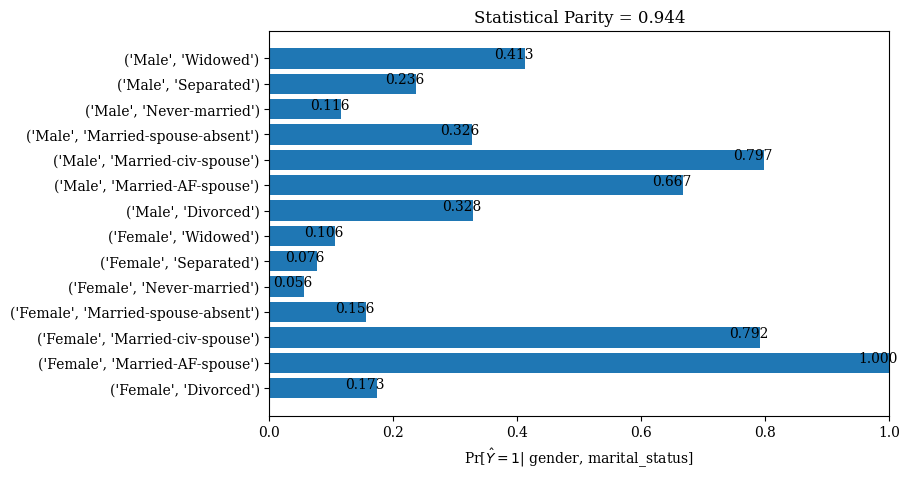

In [79]:
# Plot bar chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(groups, values)

# Add value labels on bars
for i, v in enumerate(values):
    ax.text(v - 0.05, i, f"{v:.3f}")

# Compute Statistical Parity Difference for both features
stat_parity = demographic_parity_difference(y_true=subytest_bis, y_pred=yhat, sensitive_features=subxtest_bis[['gender', 'marital_status']])

ax.set_xlabel(r"Pr[$\hat{Y} = 1 |$ gender, marital_status]")
ax.set_title(f"Statistical Parity = {stat_parity:.3f}")
ax.set_xlim(0, 1)  # Adjust the x-axis range

plt.show()

In [80]:
eopp = equal_opportunity_difference(y_true=subytest_bis, 
                                    y_pred=yhat, 
                                    sensitive_features=subxtest_bis[['gender', 'marital_status']])
print(f"Equality of Opportunity Difference: {eopp:.3f}")

Equality of Opportunity Difference: 1.000


##### Race

In [81]:
# Compute P(Ŷ = 1 | gender, marital_status)
cond_race = MetricFrame(
    metrics=mean_prediction,
    y_true=subytest_bis,
    y_pred=yhat,
    sensitive_features=subxtest_bis[['race']]
)

In [82]:
# Extract probabilities per (gender, marital_status) group
probas = cond_race.by_group.to_dict()

groups = list(probas.keys())
values = list(probas.values())

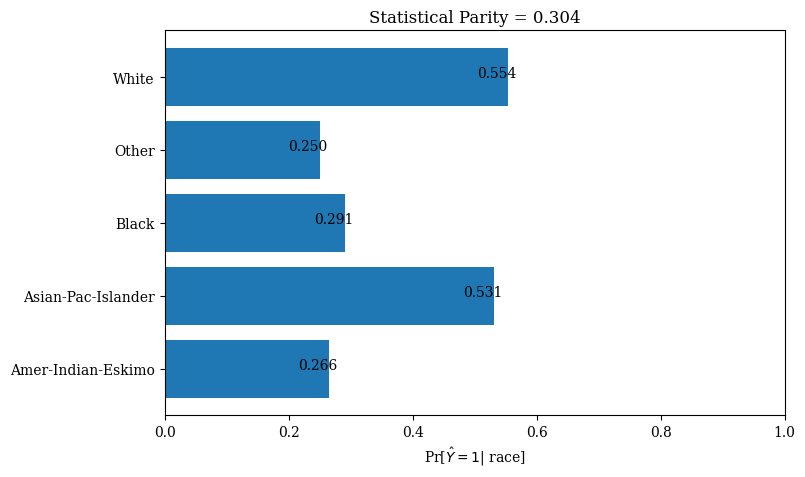

In [83]:
# Plot bar chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(groups, values)

# Add value labels on bars
for i, v in enumerate(values):
    ax.text(v - 0.05, i, f"{v:.3f}")

# Compute Statistical Parity Difference for both features
stat_parity = demographic_parity_difference(y_true=subytest_bis, y_pred=yhat, sensitive_features=subxtest_bis[['race']])

ax.set_xlabel(r"Pr[$\hat{Y} = 1 |$ race]")
ax.set_title(f"Statistical Parity = {stat_parity:.3f}")
ax.set_xlim(0, 1)  # Adjust the x-axis range

plt.show()

In [84]:
eopp = equal_opportunity_difference(y_true=subytest_bis, 
                                    y_pred=yhat, 
                                    sensitive_features=subxtest_bis['race'])
print(f"Equality of Opportunity Difference: {eopp:.3f}")

Equality of Opportunity Difference: 0.384


##### Race and gender

In [85]:
# Compute P(Ŷ = 1 | gender, marital_status)
cond_racegen = MetricFrame(
    metrics=mean_prediction,
    y_true=subytest_bis,
    y_pred=yhat,
    sensitive_features=subxtest_bis[['race', 'gender']]
)

In [86]:
# Extract probabilities per (gender, marital_status) group
probas = cond_racegen.by_group.to_dict()
groups = [str(g) for g in probas.keys()]
values = list(probas.values())

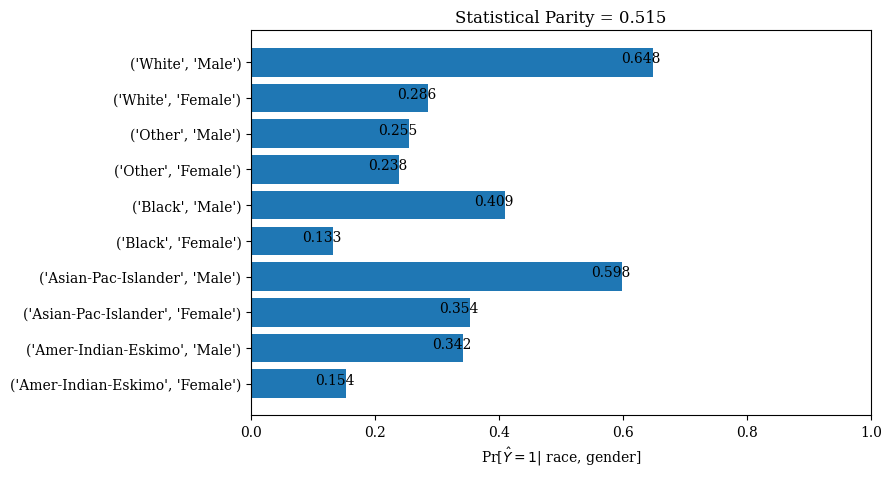

In [87]:
# Plot bar chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(groups, values)

# Add value labels on bars
for i, v in enumerate(values):
    ax.text(v - 0.05, i, f"{v:.3f}")

# Compute Statistical Parity Difference for both features
stat_parity = demographic_parity_difference(y_true=subytest_bis, y_pred=yhat, sensitive_features=subxtest_bis[['race', 'gender']])

ax.set_xlabel(r"Pr[$\hat{Y} = 1 |$ race, gender]")
ax.set_title(f"Statistical Parity = {stat_parity:.3f}")
ax.set_xlim(0, 1)  # Adjust the x-axis range

plt.show()

In [88]:
eopp = equal_opportunity_difference(y_true=subytest_bis, 
                                    y_pred=yhat, 
                                    sensitive_features=subxtest_bis[['race', 'gender']])
print(f"Equality of Opportunity Difference: {eopp:.3f}")

Equality of Opportunity Difference: 0.562


## Improving fairness by a pre-processing fairness algorithm

In [89]:
encoded_df_train = subxtest_bis.copy()
encoded_df_train['target'] = y_train

encoded_df_test = subxtest_bis.copy()
encoded_df_test['target'] = y_test


binary_label_dataset_train = aif360.datasets.BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=encoded_df_train,
    label_names=['target'],
    protected_attribute_names=['gender'])
binary_label_dataset_test = aif360.datasets.BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=encoded_df_test,
    label_names=['target'],
    protected_attribute_names=['gender'])

ValueError: could not convert string to float: 'Private'


ValueError: DataFrame values must be numerical.

In [ ]:
# Reweighing algorithm
rw = Reweighing(unprivileged_groups=[{'gender_Female' : 1}], privileged_groups=[{'gender_Female' : 0}])
rw.fit(binary_label_dataset_train)

binary_label_dataset_trans_train = rw.transform(binary_label_dataset_train)
dataset_transf_train = binary_label_dataset_trans_train.convert_to_dataframe()[0]
dataset_transf_test = rw.transform(binary_label_dataset_test).convert_to_dataframe()[0]

X_trans_train = dataset_transf_train.drop(['target'], axis = 1)
y_trans_train = dataset_transf_train['target']

X_trans_test = dataset_transf_test.drop(['target'], axis = 1)
y_trans_test = dataset_transf_test['target']

##### Retraining after fairness repair

In [ ]:
# Define the MLP model
mlp_trans = Sequential([
        Input(shape=(X_trans_train.shape[1],)),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

In [ ]:
# Compilation and training
mlp_trans.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
mlp_trans.fit(X_trans_train, y_trans_train, epochs=100, batch_size=32, verbose=0)

In [ ]:
# Evaluate the model
yhat_train_trans = (mlp_trans.predict(X_trans_train) >= 0.5).astype(int).ravel()
print("MLP Training Accuracy on train set :", accuracy_score(y_trans_train, yhat_train_trans))

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MLP Training Accuracy on train set : 0.8481539261570463


In [ ]:
yhat_trans = (mlp_trans.predict(X_trans_test) >= 0.5).astype(int).ravel()

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Statistical Parity Before:  0.359
Statistical Parity After:  0.076


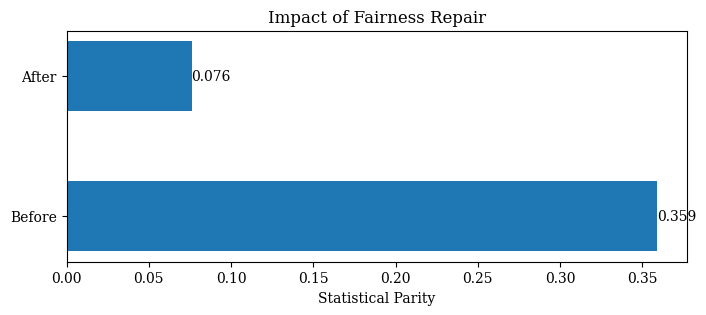

<Figure size 800x300 with 0 Axes>

In [ ]:
statistical_parity_before = round(demographic_parity_difference(y_true=subytest_bis, y_pred=yhat, sensitive_features=subxtest_bis['gender']), 3)
statistical_parity_after = round(demographic_parity_difference(y_true=y_trans_test, y_pred=yhat_trans, sensitive_features=X_trans_test['gender_Female']), 3)

print("Statistical Parity Before: ", statistical_parity_before)
print("Statistical Parity After: ", statistical_parity_after)

# bar plot of statistical parity before and after
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.figsize'] = (8, 3)
fig, ax = plt.subplots()
bars = ax.barh(['Before', 'After'], [statistical_parity_before, statistical_parity_after], 0.5)
ax.bar_label(bars)
plt.xlabel("Statistical Parity")
plt.title("Impact of Fairness Repair")
plt.show()
plt.clf()

In [92]:
eopp_before = equal_opportunity_difference(y_true=subytest_bis, 
                                    y_pred=yhat, 
                                    sensitive_features=subxtest_bis['gender'])
eopp_after = equal_opportunity_difference(y_true=y_trans_test, 
                                    y_pred=yhat_trans, 
                                    sensitive_features=X_trans_test['gender_Female'])
print(f"Equality of Opportunity Difference before: {eopp_before:.3f}")
print(f"Equality of Opportunity Difference after: {eopp_after:.3f}")

Equality of Opportunity Difference before: 0.132
Equality of Opportunity Difference after: 0.101


## Explaining the sources of unfairness

##### Gender

In [ ]:

# Set the start method to 'spawn' for Windows
multiprocessing.set_start_method('spawn', force=True)

# Your existing code
fairXplainer = FairXplainer(mlp, subxtest, ['gender_Female'])
fairXplainer.compute(maxorder=2, spline_intervals=3, verbose=False, cpu_time=500, compute_sp_only=True)


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step


In [ ]:
help(FairXplainer.compute)

Help on function compute in module fairxplainer.fair_explainer:

compute(self, maxorder=2, lambax=0.01, spline_intervals=2, explain_sufficiency_fairness=False, approach='hdmr', compute_sp_only=False, verbose=False, seed=22, cpu_time=300)
    This code computes the variance of individual and intersectional features, the sum of which 
    equals the overall variance of the prediction of the classifier. 
    Variance computation is grouped by each sensitive group



In [54]:
fairXplainer_result = fairXplainer.get_weights()
# Affichage des résultats
print(fairXplainer_result)

KeyError: 'VarTotal'

In [53]:
k = 10
fairXplainer_result = fairXplainer.get_weights()
plt = fif_plot(fairXplainer_result,
               draw_waterfall=True,
               figure_size=(9,5),
               text_y_pad=0.2,
               xlim=None,
               result_x_pad=0.02,
               x_label="Influence on Statistical Parity"
        )
plt.tight_layout()
plt.show()
plt.clf()
# print("Exact statistical parity", fairXplainer.statistical_parity_sample())

KeyError: 'VarTotal'

In [52]:
help(fairXplainer.get_weights)


Help on method get_weights in module fairxplainer.fair_explainer:

get_weights() method of fairxplainer.fair_explainer.FairXplainer instance
    Returns the weights of the features. This is called after compute() is called.
    Only shows first order influences. Second and higher order influences are summed up.

